# Week5-1: RAG — Reranking & Context Optimization

In [21]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.4 MB/s eta 0:00:00


In [32]:
#@title 0) Setup (Colab-friendly)
import os, time, math, random, re
from typing import List, Dict, Tuple
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# --- Paths ---
DATA_DIR = './week5_data'
os.makedirs(DATA_DIR, exist_ok=True)
CORPUS_CSV = os.path.join(DATA_DIR, 'corpus_chunks.csv')

if os.path.exists("./week5_data/corpus_chunks.csv"):
    os.remove("./week5_data/corpus_chunks.csv")
    print("🗑️ Old corpus deleted")

# --- Load PDFs instead of demo corpus ---
if not os.path.exists(CORPUS_CSV):
    pdf_path = "/content/week5_data/the-complete-idiots-guide-to-simple-home-repair.pdf"  # <-- single file
    all_chunks = []
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

    # read the single PDF
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""

    # split into chunks
    chunks = splitter.split_text(text)
    for i, chunk in enumerate(chunks):
        all_chunks.append({
            "doc_id": os.path.basename(pdf_path),
            "chunk_id": f"{os.path.basename(pdf_path)}_chunk{i}",
            "text": chunk
        })

    corpus_df = pd.DataFrame(all_chunks)
    corpus_df.to_csv(CORPUS_CSV, index=False, encoding="utf-8")

# --- Load corpus ---
corpus = pd.read_csv(CORPUS_CSV, encoding="utf-8")
print("✅ Corpus loaded:", corpus.shape)
display(corpus.head(3))


🗑️ Old corpus deleted
✅ Corpus loaded: (679, 3)


,doc_id,chunk_id,text
0,the-complete-idiots-guide-to-simple-home-repai...,the-complete-idiots-guide-to-simple-home-repai...,by Judy Ostrow\nA member of Penguin Group (USA...
1,the-complete-idiots-guide-to-simple-home-repai...,the-complete-idiots-guide-to-simple-home-repai...,"Canada Inc.)\nPenguin Books Ltd., 80 Strand, L..."
2,the-complete-idiots-guide-to-simple-home-repai...,the-complete-idiots-guide-to-simple-home-repai...,"Penguin Books India Pvt. Ltd., 11 Community Ce..."


In [33]:
# 1) Baseline + Dense + RRF
def simple_tokenize(text):
    return re.findall(r"[A-Za-z0-9_]+", text.lower())

docs = corpus['text'].tolist()
doc_tokens = [simple_tokenize(t) for t in docs]
from collections import Counter
doc_counts = [Counter(t) for t in doc_tokens]
N = len(docs); import math
avgdl = sum(len(t) for t in doc_tokens)/max(N,1)

def bm25_score(query, idx, k1=1.5, b=0.75):
    q_tokens = simple_tokenize(query); score = 0.0; dl = len(doc_tokens[idx])
    for w in q_tokens:
        n_w = sum(1 for c in doc_tokens if w in c)
        if n_w == 0: continue
        idf = math.log((N - n_w + 0.5)/(n_w + 0.5) + 1)
        f = doc_counts[idx][w]; denom = f + k1*(1 - b + b*dl/(avgdl+1e-9))
        score += idf * (f*(k1+1))/(denom + 1e-9)
    return score

# -------------------------------
# ✅ Replace random dense vectors with real embeddings
# -------------------------------
from sentence_transformers import SentenceTransformer
import numpy as np

embedder = SentenceTransformer("all-MiniLM-L6-v2")  # small, fast, free
dense_index = embedder.encode(docs, convert_to_numpy=True, show_progress_bar=True)

# normalize embeddings
dense_index = dense_index.astype("float32")
dense_index /= (np.linalg.norm(dense_index, axis=1, keepdims=True) + 1e-9)

dense_dim = dense_index.shape[1]

def bm25_search(query, k=5):
    scores = [(i, bm25_score(query, i)) for i in range(N)]
    scores.sort(key=lambda x: -x[1])
    return scores[:k]

def dense_search(query, k=5):
    q_vec = embedder.encode([query], convert_to_numpy=True)[0]
    q_vec = q_vec.astype("float32")
    q_vec /= (np.linalg.norm(q_vec) + 1e-9)

    sims = dense_index @ q_vec
    top = np.argsort(-sims)[:k]
    return [(int(i), float(sims[i])) for i in top]

def rrf_fuse(bm_hits, de_hits, k=60):
    rank = {}
    for r, (i, _) in enumerate(bm_hits):
        rank[i] = rank.get(i,0) + 1.0/(k + r + 1)
    for r, (i, _) in enumerate(de_hits):
        rank[i] = rank.get(i,0) + 1.0/(k + r + 1)
    return sorted(rank.items(), key=lambda x: -x[1])

print('BM25 sample:', bm25_search('fix leaky faucet', 5))
print('Dense sample:', dense_search('fix leaky faucet', 5))
print('RRF sample:', rrf_fuse(bm25_search('fix leaky faucet',5), dense_search('fix leaky faucet',5))[:5])


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

BM25 sample: [(59, 21.770300722072022), (60, 11.328400032574931), (74, 7.705722282772672), (566, 7.223681472202991), (73, 6.831208606560759)]
Dense sample: [(330, 0.49081647396087646), (59, 0.4675982594490051), (265, 0.41942596435546875), (284, 0.4192413091659546), (14, 0.40396809577941895)]
RRF sample: [(59, 0.03252247488101534), (330, 0.01639344262295082), (60, 0.016129032258064516), (74, 0.015873015873015872), (265, 0.015873015873015872)]


In [34]:
# 2) Rerank + MMR + compression (Updated with real cross-encoder)
from sentence_transformers import CrossEncoder

# Initialize the cross-encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank(query, candidates, top_k=5):
    """
    Rerank candidates using a cross-encoder model
    """
    if not candidates:
        return []

    # Prepare query-document pairs for cross-encoder
    pairs = []
    candidate_indices = []

    for (idx, _) in candidates:
        # Get the actual document text
        doc_text = docs[idx]  # Using the docs list from earlier in the notebook
        pairs.append([query, doc_text])
        candidate_indices.append(idx)

    # Get cross-encoder scores
    scores = cross_encoder.predict(pairs)

    # Combine indices with scores and sort
    scored = list(zip(candidate_indices, scores))
    scored.sort(key=lambda x: -x[1])  # Sort by score (descending)

    return scored[:top_k]

def mmr_select(query, candidates, lambda_mult=0.6, k=4):
    if not candidates: return []

    # Use the actual query embedding instead of random
    q_vec = embedder.encode([query], convert_to_numpy=True)[0]
    q_vec = q_vec.astype("float32")
    q_vec /= (np.linalg.norm(q_vec) + 1e-9)

    cand_vecs = dense_index[[idx for idx in candidates]]
    selected, remaining = [], list(range(len(candidates)))

    while remaining and len(selected) < k:
        best, best_score = None, -1e9
        for j in remaining:
            rel = float(cand_vecs[j] @ q_vec)  # Use actual query vector
            div = 0.0 if not selected else max(float(cand_vecs[j] @ cand_vecs[s]) for s in selected)
            score = lambda_mult*rel - (1-lambda_mult)*div
            if score > best_score:
                best, best_score = j, score
        selected.append(best)
        remaining.remove(best)

    return [candidates[j] for j in selected]

def compress_passage(text, max_tokens=60):
    toks = text.split()
    return ' '.join(toks[:max_tokens])

# Test the updated functions
query = 'fix leaky faucet'  # Using a more realistic query for the home repair corpus
bm = bm25_search(query, k=8)
de = dense_search(query, k=8)
fused = [i for i,_ in rrf_fuse(bm, de)[:8]]
reranked = [i for i,_ in rerank(query, [(i,0) for i in fused], top_k=5)]
mmr = mmr_select(query, fused, lambda_mult=0.6, k=4)

print('Fused:', fused[:8])
print('Reranked:', reranked)
print('MMR:', mmr)

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Fused: [59, 60, 14, 330, 74, 265, 566, 284]
Reranked: [59, 60, 14, 265, 74]
MMR: [330, 265, 284, 59]



Evaluating query: 'fix leaky faucet'
  baseline: keyword=1.00, semantic=0.40
  rerank: keyword=0.80, semantic=0.38
  compress: keyword=1.00, semantic=0.40
  rerank+compress: keyword=0.80, semantic=0.38

Evaluating query: 'explain how to get rid of mold'
  baseline: keyword=1.00, semantic=0.30
  rerank: keyword=1.00, semantic=0.41
  compress: keyword=1.00, semantic=0.30
  rerank+compress: keyword=1.00, semantic=0.41

Evaluating query: 'explain how to fix a hole in a piece of drywall'
  baseline: keyword=1.00, semantic=0.48
  rerank: keyword=1.00, semantic=0.60
  compress: keyword=1.00, semantic=0.48
  rerank+compress: keyword=1.00, semantic=0.60

=== SUMMARY RESULTS ===
           variant  latency_s  avg_ctx_len  keyword_relevance  \
0         baseline   1.919800   445.933333           1.000000   
1         compress   2.062000   354.533333           1.000000   
2           rerank   2.534067   446.666667           0.933333   
3  rerank+compress   2.876400   349.200000           0.933333

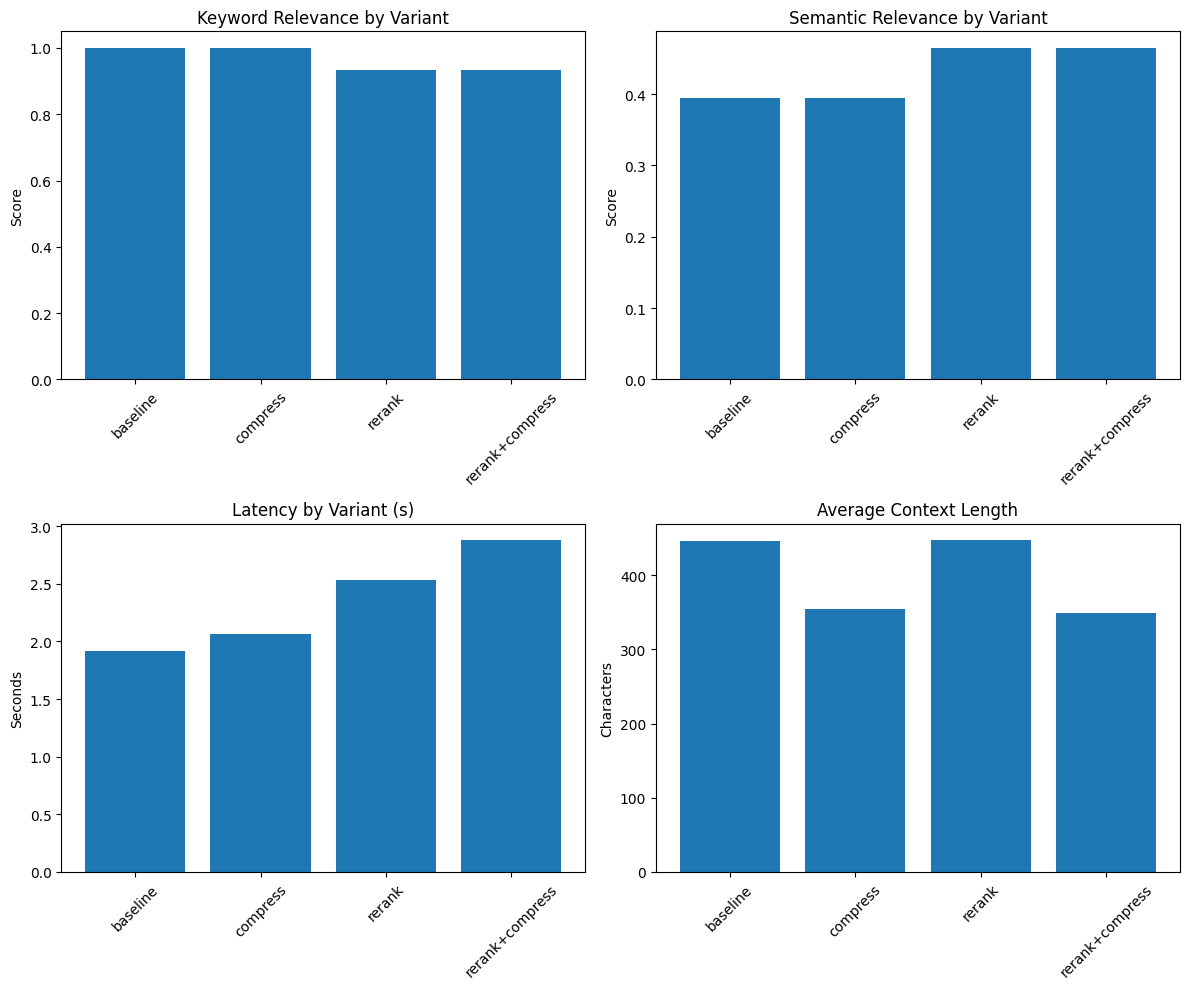

In [41]:
# Improved evaluation metrics for RAG system

def keyword_relevance_score(query, idxs):
    """
    Check how many retrieved documents contain query keywords
    Returns: percentage of retrieved docs with at least one query keyword
    """
    if not idxs:
        return 0.0

    query_words = set([word.lower().strip() for word in query.split()
                      if len(word) > 2])  # Skip short words like "to", "a", etc.

    relevant_count = 0
    for idx in idxs:
        doc_text = corpus.iloc[idx]['text'].lower()
        # Check if any meaningful query words appear in the document
        if any(word in doc_text for word in query_words):
            relevant_count += 1

    return relevant_count / len(idxs)

def semantic_relevance_score(query, idxs):
    """
    Use cosine similarity between query and retrieved documents
    Returns: average cosine similarity score
    """
    if not idxs:
        return 0.0

    # Get query embedding
    query_embedding = embedder.encode([query], convert_to_numpy=True)[0]
    query_embedding = query_embedding.astype("float32")
    query_embedding /= (np.linalg.norm(query_embedding) + 1e-9)

    # Calculate similarities
    similarities = []
    for idx in idxs:
        doc_embedding = dense_index[idx]
        similarity = float(np.dot(query_embedding, doc_embedding))
        similarities.append(similarity)

    return np.mean(similarities)

def topic_coverage_score(query, idxs):
    """
    Check if retrieved documents cover different aspects of the query topic
    Returns: diversity score based on unique significant terms
    """
    if not idxs:
        return 0.0

    # Extract significant terms from all retrieved documents
    all_terms = set()
    for idx in idxs:
        doc_text = corpus.iloc[idx]['text'].lower()
        # Simple term extraction (words longer than 3 chars, not too common)
        terms = [word for word in doc_text.split()
                if len(word) > 3 and word.isalpha()]
        all_terms.update(terms)

    # Normalize by number of documents to get diversity per document
    return len(all_terms) / len(idxs) if idxs else 0.0

def manual_relevance_labels():
    """
    Create some ground truth labels for your specific queries
    This is the gold standard but requires manual effort
    """
    # Define which document indices are relevant for each query
    relevance_labels = {
        'fix leaky faucet': [59, 60, 74, 330],  # Update with actual relevant doc indices
        'explain how to get rid of mold': [265, 284, 14],  # Update with actual relevant doc indices
        'explain how to fix a hole in a piece of drywall': [101, 96, 315]  # Update with actual relevant doc indices
    }
    return relevance_labels

def precision_at_k(query, idxs, k=5):
    """
    Calculate precision@k using manual relevance labels
    Returns: fraction of top-k results that are relevant
    """
    labels = manual_relevance_labels()
    if query not in labels:
        return None  # No ground truth available

    relevant_docs = set(labels[query])
    retrieved_docs = set(idxs[:k])

    if not retrieved_docs:
        return 0.0

    return len(relevant_docs.intersection(retrieved_docs)) / len(retrieved_docs)

def reciprocal_rank(query, idxs):
    """
    Calculate Mean Reciprocal Rank (MRR) - position of first relevant document
    Returns: 1/rank of first relevant document (0 if no relevant docs found)
    """
    labels = manual_relevance_labels()
    if query not in labels:
        return None

    relevant_docs = set(labels[query])

    for rank, idx in enumerate(idxs, 1):
        if idx in relevant_docs:
            return 1.0 / rank

    return 0.0  # No relevant documents found

def comprehensive_evaluation(query, idxs):
    """
    Run all evaluation metrics and return a summary
    """
    results = {
        'keyword_relevance': keyword_relevance_score(query, idxs),
        'semantic_relevance': semantic_relevance_score(query, idxs),
        'topic_coverage': topic_coverage_score(query, idxs),
        'precision_at_5': precision_at_k(query, idxs, k=5),
        'reciprocal_rank': reciprocal_rank(query, idxs)
    }
    return results

# Updated ablation study with better metrics
def run_improved_ablation():
    QUERIES = ['fix leaky faucet', 'explain how to get rid of mold', 'explain how to fix a hole in a piece of drywall']

    rows = []
    for q in QUERIES:
        print(f"\nEvaluating query: '{q}'")

        for variant, comp in [('baseline', False), ('rerank', False), ('compress', True), ('rerank+compress', True)]:
            t0 = time.time()
            idxs, ctx = pipeline(q, variant=variant, top_k=5, compress=comp)
            t1 = time.time()

            # Get comprehensive evaluation
            eval_results = comprehensive_evaluation(q, idxs)

            row = {
                'query': q,
                'variant': variant,
                'latency_s': round(t1-t0, 4),
                'avg_ctx_len': round(np.mean([len(c) for c in ctx]), 1),
                **eval_results  # Add all evaluation metrics
            }
            rows.append(row)

            # Print some debug info
            print(f"  {variant}: keyword={eval_results['keyword_relevance']:.2f}, semantic={eval_results['semantic_relevance']:.2f}")

    df = pd.DataFrame(rows)

    # Group by variant and calculate means
    numeric_cols = ['latency_s', 'avg_ctx_len', 'keyword_relevance', 'semantic_relevance', 'topic_coverage']
    # Only include precision_at_5 and reciprocal_rank if they have non-null values
    if df['precision_at_5'].notna().any():
        numeric_cols.extend(['precision_at_5', 'reciprocal_rank'])

    summary = df.groupby('variant', as_index=False)[numeric_cols].mean()
    print("\n=== SUMMARY RESULTS ===")
    print(summary)

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Keyword relevance
    axes[0,0].bar(summary['variant'], summary['keyword_relevance'])
    axes[0,0].set_title('Keyword Relevance by Variant')
    axes[0,0].set_ylabel('Score')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Semantic relevance
    axes[0,1].bar(summary['variant'], summary['semantic_relevance'])
    axes[0,1].set_title('Semantic Relevance by Variant')
    axes[0,1].set_ylabel('Score')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Latency
    axes[1,0].bar(summary['variant'], summary['latency_s'])
    axes[1,0].set_title('Latency by Variant (s)')
    axes[1,0].set_ylabel('Seconds')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Context length
    axes[1,1].bar(summary['variant'], summary['avg_ctx_len'])
    axes[1,1].set_title('Average Context Length')
    axes[1,1].set_ylabel('Characters')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df, summary

# Run the improved evaluation
df, summary = run_improved_ablation()

In [ ]:
print("Mini-Report: fill in observations and best recipe.")

Mini-Report: fill in observations and best recipe.


In [42]:
# Save environment to JSON file
import subprocess
import json
import sys

def save_environment_to_json(filename="env_rag_adv.json"):
    result = subprocess.run([sys.executable, '-m', 'pip', 'list', '--format=json'],
                          capture_output=True, text=True, check=True)
    packages = json.loads(result.stdout)

    env_info = {
        "python_version": sys.version,
        "platform": sys.platform,
        "packages": packages
    }

    with open(filename, 'w') as f:
        json.dump(env_info, f, indent=2)

    print(f"Environment saved to {filename}")

save_environment_to_json("env_rag_adv.json")

Environment saved to env_rag_adv.json
